# 01_EDA – Análisis Exploratorio de Datos  
Este notebook corresponde a la fase **Data Understanding** (CRISP‑DM) del caso de forecasting M + 2.

Se trabajará con:
- Ventas (`sell-in_muestra.txt`)
- Maestro de productos (`tb_productos.txt`)
- Stocks (`tb_stocks.txt`)

Y se desarrollarán tres bloques de análisis:  
**Top‑Down**, **Bottom‑Up** y **Patrones de Intermitencia**.  
Además se generará un *dataset integrado* listo para la siguiente fase de *Data Preparation*.


### Librerías y constantes  
En la siguiente celda cargamos las librerías de análisis de datos y visualización, junto con las rutas de los archivos de entrada (asegúrate de que existan en la ubicación especificada).

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import interact

# --- Rutas de datos ---
DATA_PATH = r"C:\Developer\Laboratorio_III\data"
SELL_IN_FILE = DATA_PATH + r"\sell-in.txt"
PRODUCT_FILE = DATA_PATH + r"\tb_productos.txt"
STOCK_FILE = DATA_PATH + r"\tb_stocks.txt"


### Carga de datasets  
Leemos los tres archivos TXT (delimitados por tabulaciones) y realizamos una primera inspección.  
> **Nota:** El campo `periodo` se trata como **entero** porque en los archivos de origen ya viene de esa forma y será clave de unión entre tablas.

In [2]:

def load_txt(path, **kwargs):
    return pd.read_csv(path, sep="\t", engine="python", **kwargs)

df_sales  = load_txt(SELL_IN_FILE)
df_prod   = load_txt(PRODUCT_FILE)
df_stock  = load_txt(STOCK_FILE)

# Verificamos tipo de dato de 'periodo'
for df in [df_sales, df_stock]:
    if df['periodo'].dtype != 'object':
        df['periodo'] = df['periodo'].astype('int64')

display(df_sales.head(), df_prod.head(), df_stock.head())


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa
4,FOODS,ADEREZOS,Chimichurri,NATURA,350,20797,Chimichurri


,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


### Estado inicial de los datos  
Mostramos estructura y porcentaje de valores faltantes para entender calidad y posibles saneos.

In [3]:

for nombre, df in [('Ventas', df_sales), ('Productos', df_prod), ('Stocks', df_stock)]:
    print(f"\n── {nombre} ──")
    display(df.info())
    display(df.isna().mean().rename('%NA'))



── Ventas ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB


None

periodo                  0.0
customer_id              0.0
product_id               0.0
plan_precios_cuidados    0.0
cust_request_qty         0.0
cust_request_tn          0.0
tn                       0.0
Name: %NA, dtype: float64


── Productos ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   cat1         1251 non-null   object
 1   cat2         1251 non-null   object
 2   cat3         1251 non-null   object
 3   brand        1251 non-null   object
 4   sku_size     1251 non-null   int64 
 5   product_id   1251 non-null   int64 
 6   descripcion  1251 non-null   object
dtypes: int64(2), object(5)
memory usage: 68.5+ KB


None

cat1           0.0
cat2           0.0
cat3           0.0
brand          0.0
sku_size       0.0
product_id     0.0
descripcion    0.0
Name: %NA, dtype: float64


── Stocks ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13691 entries, 0 to 13690
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   periodo      13691 non-null  int64  
 1   product_id   13691 non-null  int64  
 2   stock_final  13691 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 321.0 KB


None

periodo        0.0
product_id     0.0
stock_final    0.0
Name: %NA, dtype: float64

### Integración de datos  
Unimos las tres fuentes sobre las claves `product_id` y `periodo` (cuando aplica) para obtener un **dataset unificado** (`df_all`). Guardamos el resultado en formato Parquet para reutilizarlo.

In [4]:

df_all = (df_sales
          .merge(df_prod,  on='product_id',              how='left')
          .merge(df_stock, on=['product_id', 'periodo'], how='left')
         )

# Orden cronológico
df_all = df_all.sort_values(['periodo', 'product_id'])

df_all.to_parquet(DATA_PATH + r"\dataset_integrado.parquet")
print("Shape del dataset integrado:", df_all.shape)
df_all.head()


Shape del dataset integrado: (2945818, 14)


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final
44019,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44020,201701,10063,20001,0,1,0.12312,0.12312,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44021,201701,10080,20001,0,1,0.24625,0.24625,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44022,201701,10094,20001,0,1,1.23123,1.23123,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN
44023,201701,10184,20001,0,1,0.06716,0.06716,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN


## Análisis Top‑Down  
El enfoque Top‑Down parte del total del negocio y baja a nivel de **familia de productos** (`cat1`). Nos permite detectar tendencias globales y estacionalidad antes de profundizar en SKU.

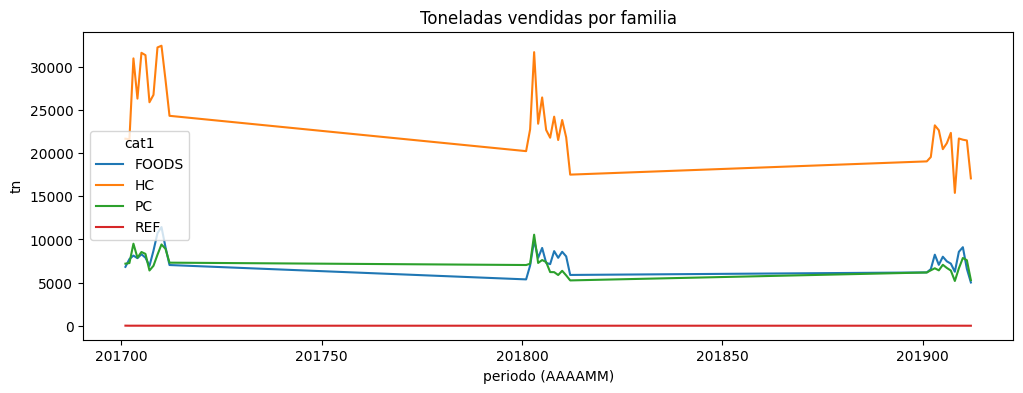

interactive(children=(Dropdown(description='familia', index=1, options=('FOODS', 'HC', 'PC', 'REF'), value='HC…

In [14]:

# Agregamos toneladas por periodo y familia
agg_family = (df_all
              .groupby(['periodo', 'cat1'], observed=True)['tn']
              .sum()
              .reset_index())

pivot = agg_family.pivot(index='periodo', columns='cat1', values='tn')

# Visualización estática
pivot.plot(figsize=(12,4))
plt.title('Toneladas vendidas por familia')
plt.ylabel('tn')
plt.xlabel('periodo (AAAAMM)')
plt.show()

# Visualización interactiva para profundizar en una familia
@interact(familia=sorted(df_all['cat1'].dropna().unique()))
def zoom_familia(familia='HC'):
    ts = pivot[familia]
    ts.plot(figsize=(10,3))
    plt.title(f'Ventas {familia}')
    plt.ylabel('tn')
    plt.xlabel('periodo')
    plt.show()


## Análisis Bottom‑Up  
Ahora partimos de cada **SKU** para caracterizar la importancia (ABC) y la volatilidad (XYZ) de la demanda. Esto orientará la selección de modelos por tipo de serie.

In [ ]:

# ABC basado en contribución acumulada a las ventas totales
sku_tot = df_all.groupby('product_id')['tn'].sum().sort_values(ascending=False)
cum_pct = sku_tot.cumsum() / sku_tot.sum()
abc_class = pd.cut(cum_pct, bins=[0, .8, .95, 1], labels=list('ABC'))
abc_df = pd.DataFrame({'total_tn': sku_tot, 'cum_pct': cum_pct, 'ABC': abc_class})

# XYZ usando Coeficiente de Variación de la demanda mensual
def cov(series):
    mean = series.mean()
    return np.nan if mean == 0 else series.std()/mean

cov_vals = df_all.groupby('product_id')['tn'].apply(cov)
xyz_class = pd.cut(cov_vals, bins=[-np.inf, .5, 1, np.inf], labels=list('XYZ'))
abc_df['XYZ'] = xyz_class

display(abc_df.head())

# Heatmap ABC‑XYZ
matrix = pd.crosstab(abc_df['ABC'], abc_df['XYZ'])
sns.heatmap(matrix, annot=True, fmt='d')
plt.title('Matriz ABC‑XYZ')
plt.show()


### Intermitencia de la demanda  
Evaluamos qué tan frecuentes son las ventas por SKU (0 = ventas todos los meses, 1 = nunca). Series muy intermitentes requerirán técnicas específicas (p.ej., Croston).

In [ ]:

# Matriz periodo × SKU
sku_mat = df_all.pivot_table(index='periodo', columns='product_id', values='tn', fill_value=0)

def intermittency(series):
    return 1 - (series > 0).sum() / len(series)

interm_values = sku_mat.apply(intermittency).sort_values()

interm_values.hist(bins=20, figsize=(6,3))
plt.title('Distribución de intermitencia por SKU')
plt.xlabel('Intermitencia (0‑1)')
plt.show()


## Resumen de hallazgos preliminares  
Guardamos un *diccionario* con métricas clave del dataset para referencia rápida.

In [ ]:

resumen = {
    'total_skus': df_prod['product_id'].nunique(),
    'rango_periodo': (df_all['periodo'].min(), df_all['periodo'].max()),
    'intermitencia_media': interm_values.mean()
}
resumen


## Próximos pasos  
- **Ingeniería de variables temporales** (lags, ventanas móviles, flags de lanzamientos).
- Dividir en *train/test* con ventanas deslizantes (horizonte +2).
- Benchmark inicial con modelos **Naïve** y **ETS** para establecer línea base.